<h3>Description</h3>

<b>This notebook demonstrates the feature selection process and a comparative analysis to evaluate model performance for each feature selection</b>

<b>This notebook is made according to the next instructions:</b>

1. Feature Selection based measurement:
- divide the data to train, validation, and test sets
- train a RF model with basic hyperparameters (max_depth = 4, trees = 100) on the train set
- fit explainability method (each one separately).
- for each explainability method (SHAP, LIME, Permutation, etc.) one should extract the global explanation in the form of "feature impact" (aggregation of all local feature impact).
- apply absolute value on the global explanation results to get the feature importance for each XAI method.
- sort the list to have the order of the least to the most important features.
- start an iterative process of eliminating the least important feature in each iteration and store the evaluation on the train, validation, and test sets (train will be store for reporting) - for classification store accuracy, precision, recall, auc. regression - MSE, MAE
- programmatically chose the best set of features based on a chosen evaluation metric (accuracy/ precision/ MSE...). you can do that by applying argmax operation. iteration here = number of features to eliminate.
- visualization: 
* each line represents the test score w.r.t each evaluation metric in each iteration. 
* the arg max is the displayed red vertical line in the following figure.
* print the final score- this is the score over the test set.
- after applying the process for each XAI method you should display the test score side by side

<h3>Libraries import</h3>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

from explainer_comparison.feature_eliminations import get_feature_elimination_results, add_best_feature_set, plot_feature_selection_outcomes
from explainer_comparison.config import MODE


<h3>Data preprocessing</h3>

In [2]:
# read a dataset
df = pd.read_csv('../../data/german_credit_score/german_credit.csv')
df.head(2)

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1


In [3]:
# for german credit score
# data
X = df.iloc[:, 1:]
#target
y = df.Creditability

# Normalize the data
normalized_df = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(normalized_df, columns=X.columns)

In [4]:
# - divide the data to train, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.5, random_state=1) #shuffle=False, 
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.4, random_state=1) #shuffle=False, 

X_train.shape, X_val.shape, X_test.shape

((500, 20), (300, 20), (200, 20))

<h3>Defining and training a model</h3>

In [9]:
# - train a RF model with basic hyperparameters (max_depth = 4, trees = 100) on the train set
random_state = 0

# for german_credit_score
model = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=random_state)

model.fit(X_train, y_train)


RandomForestClassifier(max_depth=4, random_state=0)

<h3>Feature selection demonstration</h3>

In [10]:
# - fit explainability method (each one separately).

# - for each explainability method (SHAP, LIME, Permutation, etc.) one should extract the global explanation in the 
# form of "feature impact" (aggregation of all local feature impact).

# - apply absolute value on the global explanation results to get the feature importance for each XAI method.

# - sort the list to have the order of the least to the most important features.

# - start an iterative process of eliminating the least important feature in each iteration 
# and store the evaluation on the train, validation, and test sets (train will be store for reporting) - 
# for classification store accuracy, precision, recall, auc. regression - MSE, MAE

# choose mode: regression or classification

mode = MODE.CLASSIFICATION

list_explainers = ['shap', 'lime', 'permutation_new', 'ebm'] # 'permutation', 

results_dict = get_feature_elimination_results(list_explainers, model, X_train, y_train, X_val, y_val, X_test, y_test,\
                                                            mode, threshold=0.3, random_state=random_state, verbose=False)


SHAP


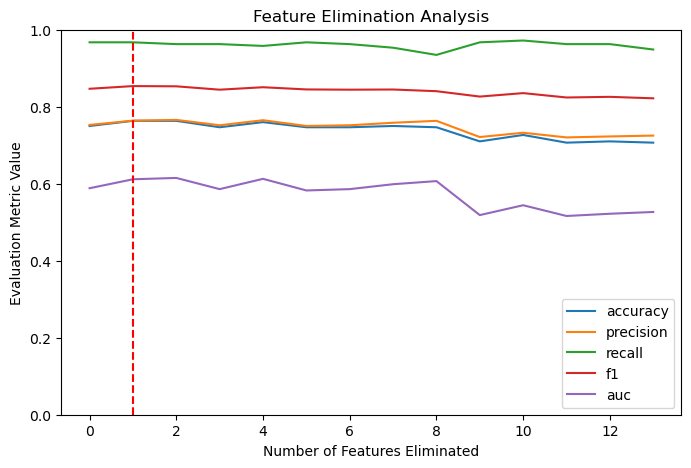

1 features are suggested to be removed
              train       val      test
accuracy   0.798000  0.763333  0.685000
precision  0.779279  0.763838  0.701087
recall     0.991404  0.967290  0.941606
f1         0.872636  0.853608  0.803738
auc        0.671199  0.611552  0.534295

LIME


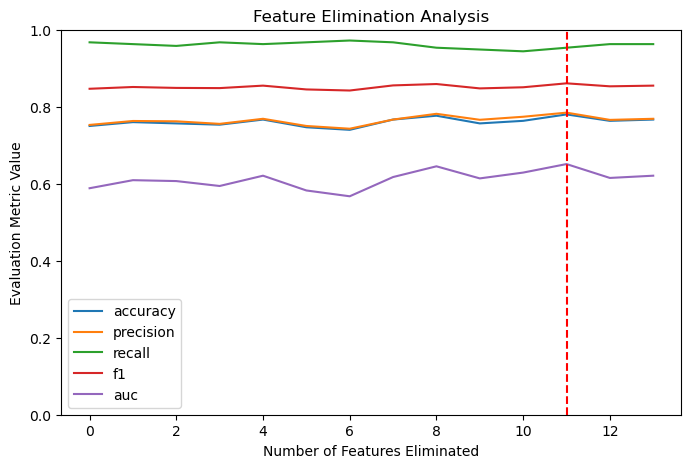

11 features are suggested to be removed
              train       val      test
accuracy   0.780000  0.780000  0.710000
precision  0.775982  0.784615  0.720670
recall     0.962751  0.953271  0.941606
f1         0.859335  0.860759  0.816456
auc        0.660183  0.651054  0.573978

PERMUTATION_NEW


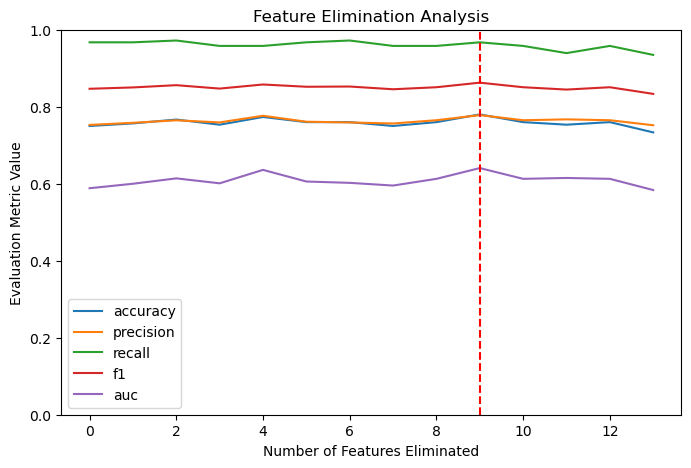

9 features are suggested to be removed
              train       val      test
accuracy   0.810000  0.780000  0.705000
precision  0.792627  0.778195  0.716667
recall     0.985673  0.967290  0.941606
f1         0.878672  0.862500  0.813880
auc        0.694823  0.640622  0.566041

EBM


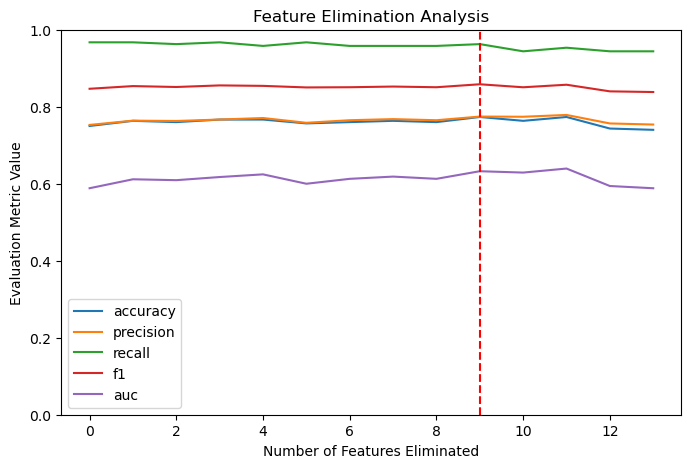

9 features are suggested to be removed
              train       val      test
accuracy   0.796000  0.773333  0.705000
precision  0.780045  0.774436  0.711957
recall     0.985673  0.962617  0.956204
f1         0.870886  0.858333  0.816199
auc        0.671645  0.632471  0.557467



In [11]:
# programmatically chose the best set of features based on a chosen evaluation metric (accuracy/ precision/ MSE...). 
# you can do that by applying argmax operation. iteration here = number of features to eliminate.

# - visualization: 
# * each line represents the test score w.r.t each evaluation metric in each iteration. 
# * the arg max is the displayed red vertical line in the following figure.

results_dict_upd = add_best_feature_set(results_dict, mode, visualization=True)

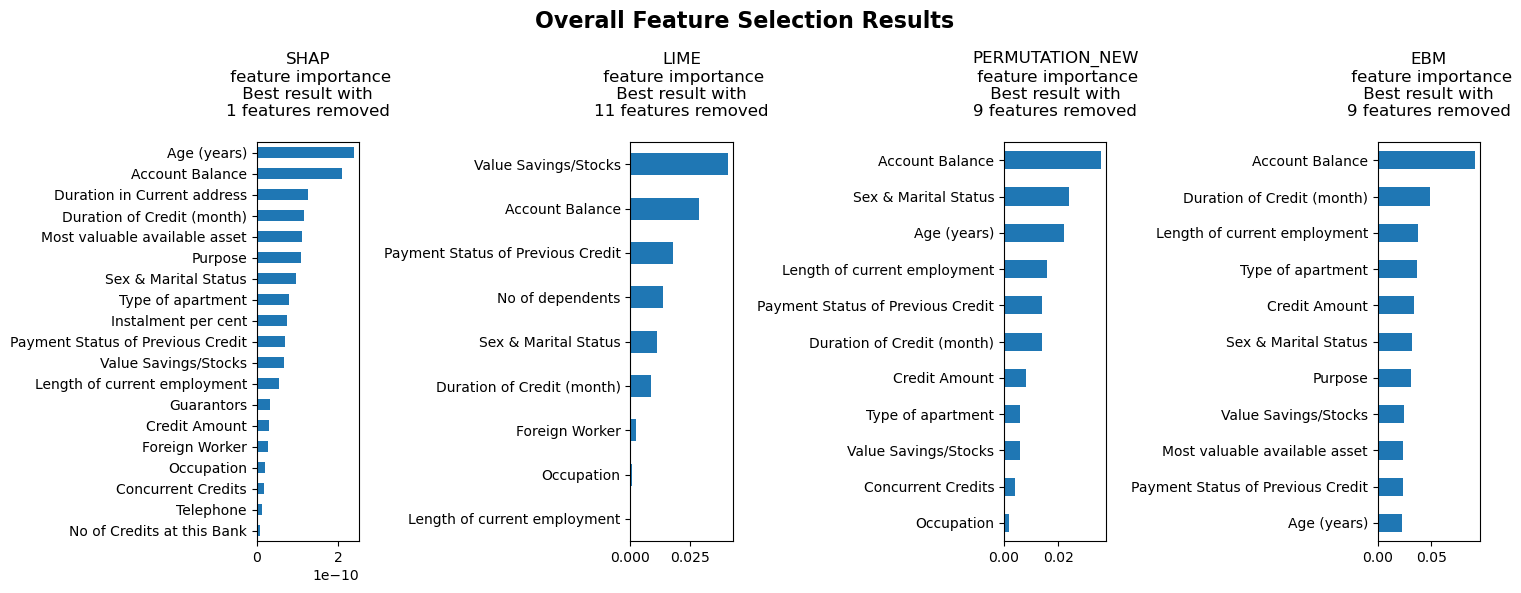

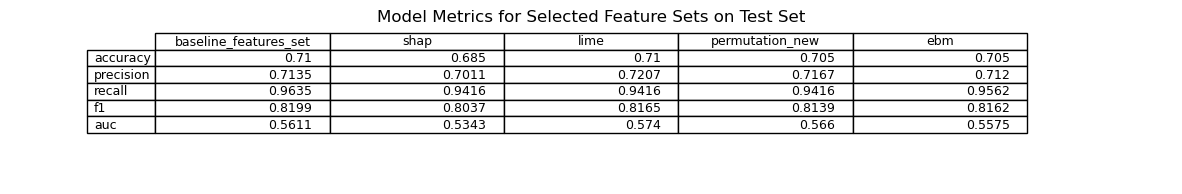

In [12]:
# * print the final score- this is the score over the test set.
# - after applying the process for each XAI method you should display the test score side by side

plot_feature_selection_outcomes(results_dict_upd)